# Analyze the fit results from `sncosmo`

Authors: Midori Rollins and Melissa Graham

*Description to go here.*

## Set up and read in the data

Import packages.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

Read in the `sncosmo` results.

In [47]:
fnm = 'all_fit_snia_files/results_sncosmos.dat'

fit_cand = np.loadtxt(fnm, dtype='str', usecols=(0))
fit_est_z = np.loadtxt(fnm, dtype='float', usecols=(1))
fit_in_zlo = np.loadtxt(fnm, dtype='float', usecols=(2))
fit_in_zhi = np.loadtxt(fnm, dtype='float', usecols=(3))
fit_z = np.loadtxt(fnm, dtype='float', usecols=(4))
fit_ze = np.loadtxt(fnm, dtype='float', usecols=(5))
fit_t0 = np.loadtxt(fnm, dtype='float', usecols=(6))
fit_t0e = np.loadtxt(fnm, dtype='float', usecols=(7))
fit_x0 = np.loadtxt(fnm, dtype='float', usecols=(8))
fit_x0e = np.loadtxt(fnm, dtype='float', usecols=(9))
fit_x1 = np.loadtxt(fnm, dtype='float', usecols=(10))
fit_x1e = np.loadtxt(fnm, dtype='float', usecols=(11))
fit_c = np.loadtxt(fnm, dtype='float', usecols=(12))
fit_ce = np.loadtxt(fnm, dtype='float', usecols=(13))

fit_pmB = np.loadtxt(fnm, dtype='float', usecols=(14))
fit_pmg = np.loadtxt(fnm, dtype='float', usecols=(15))
fit_pmr = np.loadtxt(fnm, dtype='float', usecols=(16))
fit_pmi = np.loadtxt(fnm, dtype='float', usecols=(17))

del fnm

And the review flags.

In [48]:
fnm = 'all_fit_snia_files/results_sncosmos_fit_review.dat'
fit_flag = np.loadtxt(fnm, dtype='int', usecols=(1))
fit_flagMR = np.loadtxt(fnm, dtype='int', usecols=(2))
del fnm

## A primer on the SALT2 fit parameters

We have used `sncosmo` with the SALT-2 lightcurve fitter,
(<a href="https://ui.adsabs.harvard.edu/abs/2007A%26A...466...11G/abstract">Guy et al. 2007</a>).

The five fit parameters are:
 * `z`  : redshift
 * `t0` : time of peak brightness (MJD)
 * `x0` : flux normalization (a proxy for peak brightness)
 * `x1` : a proxy for lightcurve decline rate (or stretch factor)
 * `c`  : color offset
 
### `z` and `t0`

These two are standard, self-explanatory parameters and do not need any further conversions.

### `x0` 

This is the SED normalization in the SALT2 fits, and a conversion from it to 
peak apparent brightness can be done with 
$m_{B} = −2.5\log(x_{0}) + 10.635$ 
from <a href="https://arxiv.org/abs/1401.4065">Mosher et al. (2014)</a>.

However, this isn't necessary as the peak brightness in Bessel B, and sdss g, r, and i 
are all in the fit results file already.


### `x1`

#### Decline rate

$\Delta m_{15}$ is the change in magnitude (it is standard to report this in the B-band)
during the first 15 days after peak brightness, and is commonly refered to as the
decline rate.

Section 5 of Guy+07 gives the conversion between $x_1$ and $\Delta m_{15}$ as:

> $\Delta m_{15} = 1.09 - 0.161x_{1} + 0.013x_{1}^{2} - 0.00130x_{1}^{3}$

SNIa with a larger value of $\Delta m_{15}$ decline faster, and typically have reached
fainter peak brightness.

#### Stretch

The stretch parameter, $s$, is another parameterization of the width or decline rate
of the SNIa which also incorporates the rise time, and was defined in
<a href="https://ui.adsabs.harvard.edu/abs/1997ApJ...483..565P/abstract">Perlmutter et al. 1997</a>.

Section 5 of Guy+07 gives the conversion between $x_1$ and $s$ as:

> $s = 0.98 + 0.091 x_1 + 0.003 x_1^2 - 0.00075 x_1^3$

SNIa with a larger stretch value have a narrower-width lightcurve that has reached a fainter peak.


### `c` 

Section 2 of Guy+07 describes this as 
*"...a color offset with respect to the average at the date maximum luminosity in B-band, 
$c = (B-V)_{\rm MAX} - \left< B-V \right>$ ..."*.

In this case, $(B-V)_{\rm MAX}$ is the color of the fit SNIa at maximum, 
and $\left< B-V \right>$ is the average color for SNIa in general.

What does the value of $c$ indicate about the fit SNIa's color? Let's reason it out:
 * When $c < 0$, that means $(B-V)_{\rm MAX} < \left< B-V \right>$.
 * The fit SNIa has a $B-V$ value that is lower than average.
 * This means either $B$ is smaller or $V$ is larger.
 * Since we're in magnitudes, that means $B$ is brighter or $V$ is fainter.
 * And $B$ being brighter or $V$ being fainter means the SNIa is *bluer*.
 * So when $c < 0$, the fit SNIa is bluer than a typical SNIa.
 * And vice versa, when $c > 0$ the fit SNIa is redder than a typical SNIa.

This is important to understand because SNIa that are intrinsically brighter are bluer,
and we should see this correlation in our fit results.

## Convert parameters and calculate errors

### Convert `x1` to $\Delta m_{15}$ and stretch

Determine the error values analytically.

#### $\Delta m_{15}$

In [49]:
fit_dm15 = 1.09 - 0.161*fit_x1 + 0.013*fit_x1**2 - 0.00130*fit_x1**3
fit_dm15e = np.zeros(len(fit_dm15), dtype='float')
for c in range(len(fit_dm15)):
    if fit_x1e[c] > 0:
        temp = np.random.normal(loc=fit_x1[c], scale=fit_x1e[c], size=10000)
        temp2 = 1.09 - 0.161*temp + 0.013*temp**2 - 0.00130*temp**3
        fit_dm15e[c] = np.std(temp2)
        del temp, temp2
    else:
        fit_dm15e[c] = -99.9

#### Stretch

In [50]:
fit_s = 0.98 + 0.091*fit_x1 + 0.003*fit_x1**2 - 0.00075*fit_x1**3
fit_se = np.zeros(len(fit_s), dtype='float')
for c in range(len(fit_s)):
    if fit_x1e[c] > 0:
        temp = np.random.normal(loc=fit_x1[c], scale=fit_x1e[c], size=10000)
        temp2 = 0.98 + 0.091*temp + 0.003*temp**2 - 0.00075*temp**3
        fit_se[c] = np.std(temp2)
        del temp, temp2
    else:
        fit_se[c] = -99.9

### Calculate error in peak apparent brightness

Derive an error in peak brightness from the error in the fit value of `x0`.

In [51]:
fit_pmfe = np.zeros(len(fit_x0e), dtype='float')
for c in range(len(fit_x0e)):
    if fit_x0e[c] > 0:
        temp = np.random.normal(loc=fit_x0[c], scale=fit_x0e[c], size=10000)
        temp2 = -2.5 * np.log10(temp) + 10.635
        fit_pmfe[c] = np.std(temp2)
        del temp, temp2
    else:
        fit_pmfe[c] = -99.9

/tmp/ipykernel_1985337/44849587.py:5: RuntimeWarning: invalid value encountered in log10
  temp2 = -2.5 * np.log10(temp) + 10.635


### Estimate peak intrinsic magnitude: $ M_{B}$

Since we have the redshift from the fit, determine the distance modulus and
calculate the peak intrinsic magnitude of each potential SNIa.

The simple way to do this is to use $\mu = m-M$ where $\mu = 5log(D_L) + 25$.

In [52]:
fit_MB = np.zeros(len(fit_pmB), dtype='float')
tx = np.where(fit_z > 0.0)[0]
fit_MB[tx] = fit_pmB[tx] - (5. * np.log10(cosmo.luminosity_distance(fit_z[tx]).value) + 25.)
del tx

In [53]:
fit_MBe = np.zeros(len(fit_MB), dtype='float')
for c in range(len(fit_MB)):
    if fit_z[c] > 0.0:
        temp = np.random.normal(loc=fit_z[c], scale=fit_ze[c], size=10000)
        temp2 = np.random.normal(loc=fit_pmB[c], scale=fit_pmfe[c], size=10000)
        temp3 = temp2 - (5. * np.log10(cosmo.luminosity_distance(temp).value) + 25.)
        fit_MBe[c] = np.std(temp3)
        del temp, temp2, temp3
    else:
        fit_MBe[c] = -99.9

/tmp/ipykernel_1985337/4282898857.py:6: RuntimeWarning: invalid value encountered in log10
  temp3 = temp2 - (5. * np.log10(cosmo.luminosity_distance(temp).value) + 25.)


Can we use the lightcurve fits to get a "corrected" peak magnitude?

For example, by using this equation from Section 7.2 in Guy+07:

$\mu_B = m^{*}_B - M + \alpha_x \times x_1 - \beta \times c$

This can get you a better *distance* but it relies on the assumption that all SNIa can be "corrected" to a common peak brightness.

Using this equation does not result in a more accurate calculation of the true intrinsic peak brightness.

## Plot parameter correlations

Only include potential SNIa with *unflagged* fit parameters in the plots.

In [54]:
tx = np.where((fit_z > 0.0) & (fit_flag == 0))[0]
tx2 = np.where((fit_z > 0.0) & (fit_flagMR == 0))[0]
# tx3 = np.where((fit_z > 0.0) & (fit_flag ==0) & (fit_flagMR == 0))[0]

## SALT2 parameters

As a function of redshift.

Only `x0`, the peak apparent magnitude, should be correlated with redshift.

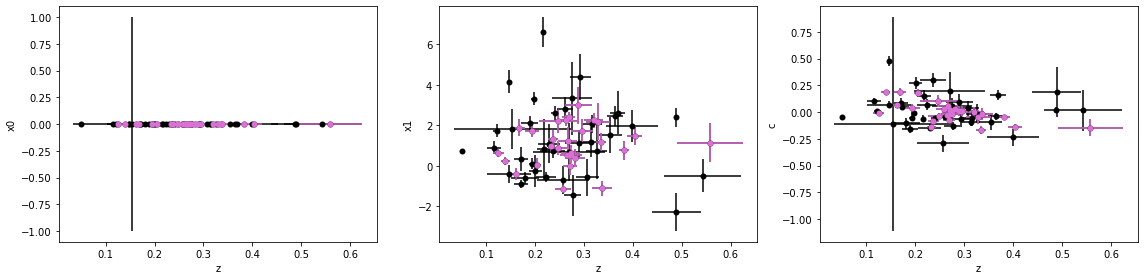

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=False)

ax[0].errorbar(fit_z[tx], fit_x0[tx], fmt='o', xerr=fit_ze[tx], yerr=fit_x0e[tx], mew=0, color='black')
ax[0].errorbar(fit_z[tx2], fit_x0[tx2], fmt='o', xerr=fit_ze[tx2], yerr=fit_x0e[tx2], mew=0, color='orchid')
ax[0].set_xlabel('z')
ax[0].set_ylabel('x0')

ax[1].errorbar(fit_z[tx], fit_x1[tx], fmt='o', xerr=fit_ze[tx], yerr=fit_x1e[tx], mew=0, color='black')
ax[1].errorbar(fit_z[tx2], fit_x1[tx2], fmt='o', xerr=fit_ze[tx2], yerr=fit_x1e[tx2], mew=0, color='orchid')
ax[1].set_xlabel('z')
ax[1].set_ylabel('x1')

ax[2].errorbar(fit_z[tx], fit_c[tx], fmt='o', xerr=fit_ze[tx], yerr=fit_ce[tx], mew=0, color='black')
ax[2].errorbar(fit_z[tx2], fit_c[tx2], fmt='o', xerr=fit_ze[tx2], yerr=fit_ce[tx2], mew=0, color='orchid')
ax[2].set_xlabel('z')
ax[2].set_ylabel('c')

fig.tight_layout()
fig.show()

Each parameter vs. the other. We should not see any correlations here, as the three parameters should be independent.

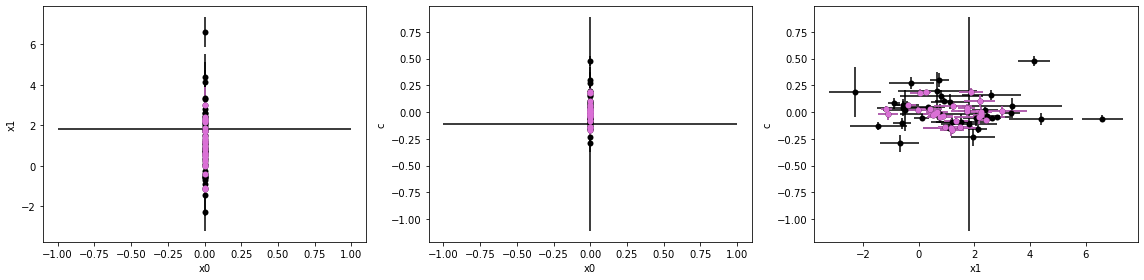

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=False, sharey=False)

tx = np.where((fit_z > 0.0) & (fit_flag == 0))[0]
                           
ax[0].errorbar(fit_x0[tx], fit_x1[tx], fmt='o', xerr=fit_x0e[tx], yerr=fit_x1e[tx], mew=0, color='black')
ax[0].errorbar(fit_x0[tx2], fit_x1[tx2], fmt='o', xerr=fit_x0e[tx2], yerr=fit_x1e[tx2], mew=0, color='orchid')
ax[0].set_xlabel('x0')
ax[0].set_ylabel('x1')

ax[1].errorbar(fit_x0[tx], fit_c[tx], fmt='o', xerr=fit_x0e[tx], yerr=fit_ce[tx], mew=0, color='black')
ax[1].errorbar(fit_x0[tx2], fit_c[tx2], fmt='o', xerr=fit_x0e[tx2], yerr=fit_ce[tx2], mew=0, color='orchid')
ax[1].set_xlabel('x0')
ax[1].set_ylabel('c')

ax[2].errorbar(fit_x1[tx], fit_c[tx], fmt='o', xerr=fit_x1e[tx], yerr=fit_ce[tx], mew=0, color='black')
ax[2].errorbar(fit_x1[tx2], fit_c[tx2], fmt='o', xerr=fit_x1e[tx2], yerr=fit_ce[tx2], mew=0, color='orchid')
ax[2].set_xlabel('x1')
ax[2].set_ylabel('c')

fig.tight_layout()
fig.show()

### Derived lightcurve parameters and redshift

Here we absolutely expect to see a clear trend between peak apparent magnitude and redshift, 
but not between redshift for stretch or $\Delta m_{15}$.

While we didn't expect the trend between $m$ and $z$ to be linear, the scatter at lower redshifts is odd.

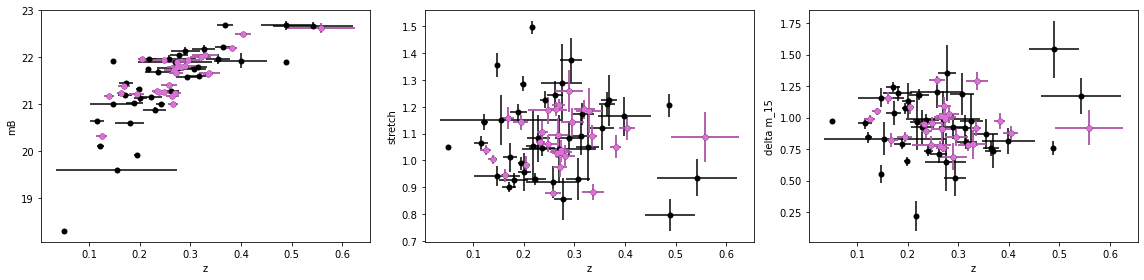

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=False)

ax[0].errorbar(fit_z[tx], fit_pmB[tx], fmt='o', xerr=fit_ze[tx], yerr=fit_pmfe[tx], mew=0, color='black')
ax[0].errorbar(fit_z[tx2], fit_pmB[tx2], fmt='o', xerr=fit_ze[tx2], yerr=fit_pmfe[tx2], mew=0, color='orchid')
ax[0].set_xlabel('z')
ax[0].set_ylabel('mB')

ax[1].errorbar(fit_z[tx], fit_s[tx], fmt='o', xerr=fit_ze[tx], yerr=fit_se[tx], mew=0, color='black')
ax[1].errorbar(fit_z[tx2], fit_s[tx2], fmt='o', xerr=fit_ze[tx2], yerr=fit_se[tx2], mew=0, color='orchid')
ax[1].set_xlabel('z')
ax[1].set_ylabel('stretch')

ax[2].errorbar(fit_z[tx], fit_dm15[tx], fmt='o', xerr=fit_ze[tx], yerr=fit_dm15e[tx], mew=0, color='black')
ax[2].errorbar(fit_z[tx2], fit_dm15[tx2], fmt='o', xerr=fit_ze[tx2], yerr=fit_dm15e[tx2], mew=0, color='orchid')
ax[2].set_xlabel('z')
ax[2].set_ylabel('delta m_15')

fig.tight_layout()
fig.show()

Derived parameters vs. each other (+ color). We should see a trend between delta_m15 and stretch as they were both derived from x1. delta_m15 has a negative relationship with x1, stretch has positive relationship w/ x1, so delta_m15 and stretch should have negative relationship with each other, and that checks out here.

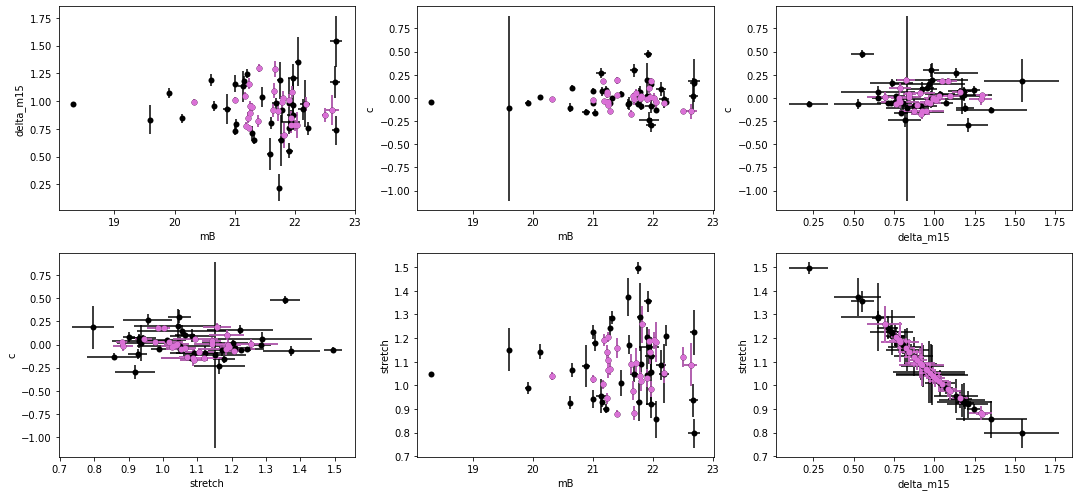

In [58]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=False, sharey=False)

ax[0,0].errorbar(fit_pmB[tx], fit_dm15[tx], fmt='o', xerr=fit_pmfe[tx], yerr=fit_dm15e[tx], mew=0, color='black')
ax[0,0].errorbar(fit_pmB[tx2], fit_dm15[tx2], fmt='o', xerr=fit_pmfe[tx2], yerr=fit_dm15e[tx2], mew=0, color='orchid')
ax[0,0].set_xlabel('mB')
ax[0,0].set_ylabel('delta_m15')

ax[0,1].errorbar(fit_pmB[tx], fit_c[tx], fmt='o', xerr=fit_pmfe[tx], yerr=fit_ce[tx], mew=0, color='black')
ax[0,1].errorbar(fit_pmB[tx2], fit_c[tx2], fmt='o', xerr=fit_pmfe[tx2], yerr=fit_ce[tx2], mew=0, color='orchid')
ax[0,1].set_xlabel('mB')
ax[0,1].set_ylabel('c')

ax[0,2].errorbar(fit_dm15[tx], fit_c[tx], fmt='o', xerr=fit_dm15e[tx], yerr=fit_ce[tx], mew=0, color='black')
ax[0,2].errorbar(fit_dm15[tx2], fit_c[tx2], fmt='o', xerr=fit_dm15e[tx2], yerr=fit_ce[tx2], mew=0, color='orchid')
ax[0,2].set_xlabel('delta_m15')
ax[0,2].set_ylabel('c')

ax[1,0].errorbar(fit_s[tx], fit_c[tx], fmt='o', xerr=fit_se[tx], yerr=fit_ce[tx], mew=0, color='black')
ax[1,0].errorbar(fit_s[tx2], fit_c[tx2], fmt='o', xerr=fit_se[tx2], yerr=fit_ce[tx2], mew=0, color='orchid')
ax[1,0].set_xlabel('stretch')
ax[1,0].set_ylabel('c')

ax[1,1].errorbar(fit_pmB[tx], fit_s[tx], fmt='o', xerr=fit_pmfe[tx], yerr=fit_se[tx], mew=0, color='black')
ax[1,1].errorbar(fit_pmB[tx2], fit_s[tx2], fmt='o', xerr=fit_pmfe[tx2], yerr=fit_se[tx2], mew=0, color='orchid')
ax[1,1].set_xlabel('mB')
ax[1,1].set_ylabel('stretch')

ax[1,2].errorbar(fit_dm15[tx], fit_s[tx], fmt='o', xerr=fit_dm15e[tx], yerr=fit_se[tx], mew=0, color='black')
ax[1,2].errorbar(fit_dm15[tx2], fit_s[tx2], fmt='o', xerr=fit_dm15e[tx2], yerr=fit_se[tx2], mew=0, color='orchid')
ax[1,2].set_xlabel('delta_m15')
ax[1,2].set_ylabel('stretch')

fig.tight_layout()
fig.show()

### Intrinsic peak brightness and redshift

Here we **DO NOT** expect to see a trend.

And yet we do, which remains concerning.

What this *might* mean is that a bunch of the lower-redshift objects (z<0.2) are not SNIa.

This trend could be entirely a result of our detection biases, where we can
more easily detect bright things if they're nearby.

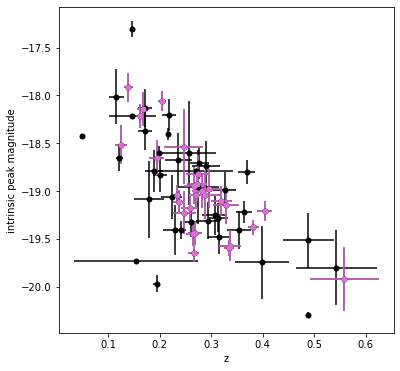

In [59]:
plt.figure(figsize=(6, 6))

plt.errorbar(fit_z[tx], fit_MB[tx], fmt='o', xerr=fit_ze[tx], yerr=fit_MBe[tx], mew=0, color='black')
plt.errorbar(fit_z[tx2], fit_MB[tx2], fmt='o', xerr=fit_ze[tx2], yerr=fit_MBe[tx2], mew=0, color='orchid')

plt.xlabel('z')
plt.ylabel('intrinsic peak magnitude')
plt.show()

### Lightcurve parameters vs. peak intrinsic magnitude

Here we do expect stretch and $\Delta m_{15}$ to be correlated with peak intrinsic magnitude.

This is commonly known as the Phillips relation, or the width-luminosity relation, from <a href="https://ui.adsabs.harvard.edu/abs/1993ApJ...413L.105P/abstract">Phillips et al. (1993)</a>.

We aren't seeing it super clearly here though....

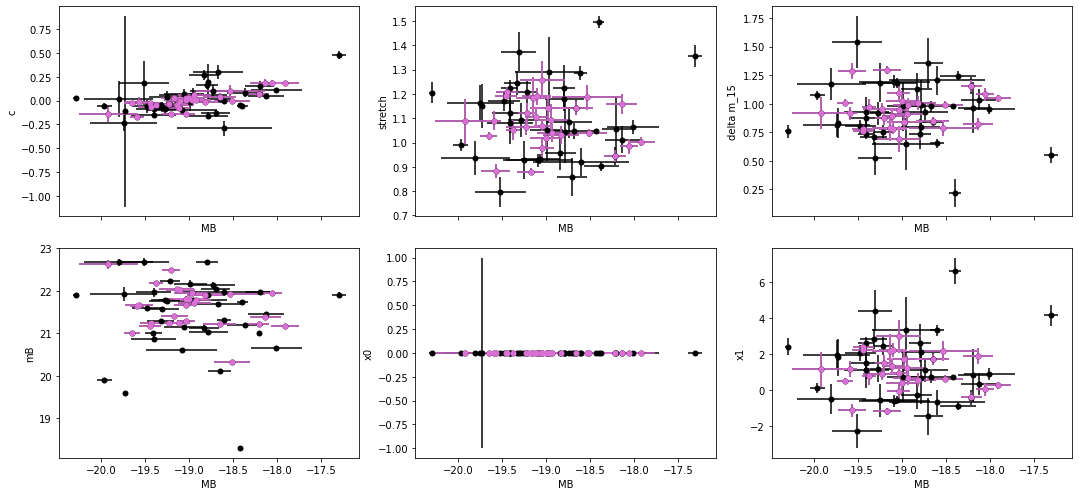

In [60]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=False)

ax[0,0].errorbar(fit_MB[tx], fit_c[tx], fmt='o', xerr=fit_MBe[tx], yerr=fit_ce[tx], mew=0, color='black')
ax[0,0].errorbar(fit_MB[tx2], fit_c[tx2], fmt='o', xerr=fit_MBe[tx2], yerr=fit_ce[tx2], mew=0, color='orchid')
ax[0,0].set_xlabel('MB')
ax[0,0].set_ylabel('c')

ax[0,1].errorbar(fit_MB[tx], fit_s[tx], fmt='o', xerr=fit_MBe[tx], yerr=fit_se[tx], mew=0, color='black')
ax[0,1].errorbar(fit_MB[tx2], fit_s[tx2], fmt='o', xerr=fit_MBe[tx2], yerr=fit_se[tx2], mew=0, color='orchid')
ax[0,1].set_xlabel('MB')
ax[0,1].set_ylabel('stretch')

ax[0,2].errorbar(fit_MB[tx], fit_dm15[tx], fmt='o', xerr=fit_MBe[tx], yerr=fit_dm15e[tx], mew=0, color='black')
ax[0,2].errorbar(fit_MB[tx2], fit_dm15[tx2], fmt='o', xerr=fit_MBe[tx2], yerr=fit_dm15e[tx2], mew=0, color='orchid')
ax[0,2].set_xlabel('MB')
ax[0,2].set_ylabel('delta m_15')

ax[1,0].errorbar(fit_MB[tx], fit_pmB[tx], fmt='o', xerr=fit_MBe[tx], yerr=fit_pmfe[tx], mew=0, color='black')
ax[1,0].errorbar(fit_MB[tx2], fit_pmB[tx2], fmt='o', xerr=fit_MBe[tx2], yerr=fit_pmfe[tx2], mew=0, color='orchid')
ax[1,0].set_xlabel('MB')
ax[1,0].set_ylabel('mB')

ax[1,1].errorbar(fit_MB[tx], fit_x0[tx], fmt='o', xerr=fit_MBe[tx], yerr=fit_x0e[tx], mew=0, color='black')
ax[1,1].errorbar(fit_MB[tx2], fit_x0[tx2], fmt='o', xerr=fit_MBe[tx2], yerr=fit_x0e[tx2], mew=0, color='orchid')
ax[1,1].set_xlabel('MB')
ax[1,1].set_ylabel('x0')

ax[1,2].errorbar(fit_MB[tx], fit_x1[tx], fmt='o', xerr=fit_MBe[tx], yerr=fit_x1e[tx], mew=0, color='black')
ax[1,2].errorbar(fit_MB[tx2], fit_x1[tx2], fmt='o', xerr=fit_MBe[tx2], yerr=fit_x1e[tx2], mew=0, color='orchid')
ax[1,2].set_xlabel('MB')
ax[1,2].set_ylabel('x1')

fig.tight_layout()
fig.show()

As described above, _"when $c < 0$, the fit SNIa is bluer than a typical SNIa"_.

The plot at left of `c` vs. `MB` does show a bluer-brighter trend, so that's reassuring.